In [1]:
pip install basemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 69.4 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

df_woa = pd.read_csv('woa_grid_shallow.csv')
df_joined = pd.read_csv('yang_woa_grid_shallow.csv')


GRID_STEP = 0.25
TOLERANCE = 0.01  # tolerancja dla dopasowania współrzędnych

# Kolejność sąsiadów: N, NE, E, SE, S, SW, W, NW
DIRECTIONS = [
    (0, GRID_STEP),
    (GRID_STEP, GRID_STEP),
    (GRID_STEP, 0),
    (GRID_STEP, -GRID_STEP),
    (0, -GRID_STEP),
    (-GRID_STEP, -GRID_STEP),
    (-GRID_STEP, 0),
    (-GRID_STEP, GRID_STEP)
]

coord_lookup = {}
for idx, row in df_woa.iterrows():
    lat_key = round(row['lat'] / TOLERANCE) * TOLERANCE
    lon_key = round(row['lon'] / TOLERANCE) * TOLERANCE
    coord_lookup[(lat_key, lon_key)] = idx

expanded_rows = []
missing_count = 0

for _, row in tqdm(df_joined.iterrows(), total=len(df_joined), desc='Znajdowanie sąsiadów'):
    base_lat = row['lat_woa']
    base_lon = row['lon_woa']

    neighbors_data = {}
    valid = True

    for dir_num, (dlat, dlon) in enumerate(DIRECTIONS, 1):
        target_lat = base_lat + dlat
        target_lon = base_lon + dlon

        lat_key = round(target_lat / TOLERANCE) * TOLERANCE
        lon_key = round(target_lon / TOLERANCE) * TOLERANCE

        if (lat_key, lon_key) in coord_lookup:
            neighbor_idx = coord_lookup[(lat_key, lon_key)]
            neighbor_row = df_woa.iloc[neighbor_idx]

            prefix = f'neigh_{dir_num}_'
            for col in neighbor_row.index:
                neighbors_data[prefix + col] = neighbor_row[col]
        else:
            valid = False
            break

    if valid:
        # połącz dane tylko jeśli znaleziono wszystkich 8 sąsiadów
        combined_row = {**row.to_dict(), **neighbors_data}
        expanded_rows.append(combined_row)
    else:
        missing_count += 1

df_result = pd.DataFrame(expanded_rows)

print(f"Znaleziono sąsiadów dla {len(df_result)} punktów ({len(df_joined)-len(df_result)} pominięto)")

Znajdowanie sąsiadów: 100%|██████████| 128559/128559 [01:25<00:00, 1504.30it/s]


Znaleziono sąsiadów dla 128508 punktów (51 pominięto)


In [2]:
df_result.columns

Index(['lat_yang', 'lon_yang', 'depth_yang', 'n2o_ppb', 'n2o_nM', 'dn2o_ppb',
       'atmPressure', 'salinity', 'lat_woa', 'lon_woa', 'temperature_00',
       'salinity_00', 'oxygen_00', 'nitrate_00', 'phosphate_00', 'depth_woa',
       'neigh_1_lat', 'neigh_1_lon', 'neigh_1_temperature_00',
       'neigh_1_salinity_00', 'neigh_1_oxygen_00', 'neigh_1_nitrate_00',
       'neigh_1_phosphate_00', 'neigh_1_depth', 'neigh_2_lat', 'neigh_2_lon',
       'neigh_2_temperature_00', 'neigh_2_salinity_00', 'neigh_2_oxygen_00',
       'neigh_2_nitrate_00', 'neigh_2_phosphate_00', 'neigh_2_depth',
       'neigh_3_lat', 'neigh_3_lon', 'neigh_3_temperature_00',
       'neigh_3_salinity_00', 'neigh_3_oxygen_00', 'neigh_3_nitrate_00',
       'neigh_3_phosphate_00', 'neigh_3_depth', 'neigh_4_lat', 'neigh_4_lon',
       'neigh_4_temperature_00', 'neigh_4_salinity_00', 'neigh_4_oxygen_00',
       'neigh_4_nitrate_00', 'neigh_4_phosphate_00', 'neigh_4_depth',
       'neigh_5_lat', 'neigh_5_lon', 'neigh_5_te

In [3]:
df_result = df_result.drop(['lat_yang', 'lon_yang', 'depth_yang', 'n2o_nM', 'n2o_ppb', 'atmPressure', 'salinity'], axis=1)

In [4]:
len(df_result.columns)

73

In [5]:
df_result.columns

Index(['dn2o_ppb', 'lat_woa', 'lon_woa', 'temperature_00', 'salinity_00',
       'oxygen_00', 'nitrate_00', 'phosphate_00', 'depth_woa', 'neigh_1_lat',
       'neigh_1_lon', 'neigh_1_temperature_00', 'neigh_1_salinity_00',
       'neigh_1_oxygen_00', 'neigh_1_nitrate_00', 'neigh_1_phosphate_00',
       'neigh_1_depth', 'neigh_2_lat', 'neigh_2_lon', 'neigh_2_temperature_00',
       'neigh_2_salinity_00', 'neigh_2_oxygen_00', 'neigh_2_nitrate_00',
       'neigh_2_phosphate_00', 'neigh_2_depth', 'neigh_3_lat', 'neigh_3_lon',
       'neigh_3_temperature_00', 'neigh_3_salinity_00', 'neigh_3_oxygen_00',
       'neigh_3_nitrate_00', 'neigh_3_phosphate_00', 'neigh_3_depth',
       'neigh_4_lat', 'neigh_4_lon', 'neigh_4_temperature_00',
       'neigh_4_salinity_00', 'neigh_4_oxygen_00', 'neigh_4_nitrate_00',
       'neigh_4_phosphate_00', 'neigh_4_depth', 'neigh_5_lat', 'neigh_5_lon',
       'neigh_5_temperature_00', 'neigh_5_salinity_00', 'neigh_5_oxygen_00',
       'neigh_5_nitrate_00', 'neig

In [6]:
def random_geo_patches(df, lat_col='lat', lon_col='lon',
                       patch_deg=10, n_patches=40, seed=42):
    rng = np.random.RandomState(seed)

    lat_min, lat_max = df[lat_col].min(), df[lat_col].max()
    lon_min, lon_max = df[lon_col].min(), df[lon_col].max()

    lat_bins = np.arange(np.floor(lat_min / patch_deg) * patch_deg,
                         np.ceil(lat_max / patch_deg) * patch_deg + patch_deg,
                         patch_deg)
    lon_bins = np.arange(np.floor(lon_min / patch_deg) * patch_deg,
                         np.ceil(lon_max / patch_deg) * patch_deg + patch_deg,
                         patch_deg)

    grid = [(lat_bins[i], lat_bins[i]+patch_deg,
             lon_bins[j], lon_bins[j]+patch_deg)
            for i in range(len(lat_bins)-1)
            for j in range(len(lon_bins)-1)]

    rng.shuffle(grid)

    selected = []
    mask = np.zeros(len(df), dtype=bool)
    for bbox in grid:
        if len(selected) >= n_patches:
            break
        la0, la1, lo0, lo1 = bbox
        inside = (
            df[lat_col].between(la0, la1, inclusive="left") &
            df[lon_col].between(lo0, lo1, inclusive="left")
        )
        if inside.any():
            selected.append(bbox)
            mask |= inside

    return selected, mask


In [7]:
patch_list, global_test_mask = random_geo_patches(
    df_result,
    lat_col='lat_woa',
    lon_col='lon_woa',
    patch_deg=10,
    n_patches=40,
    seed=42
)

print(f"Train: {(~global_test_mask).sum():,d}  |  Test: {global_test_mask.sum():,d} "
      f"({global_test_mask.mean():.2%} of total) in {len(patch_list)} patches")


Train: 114,620  |  Test: 13,888 (10.81% of total) in 40 patches


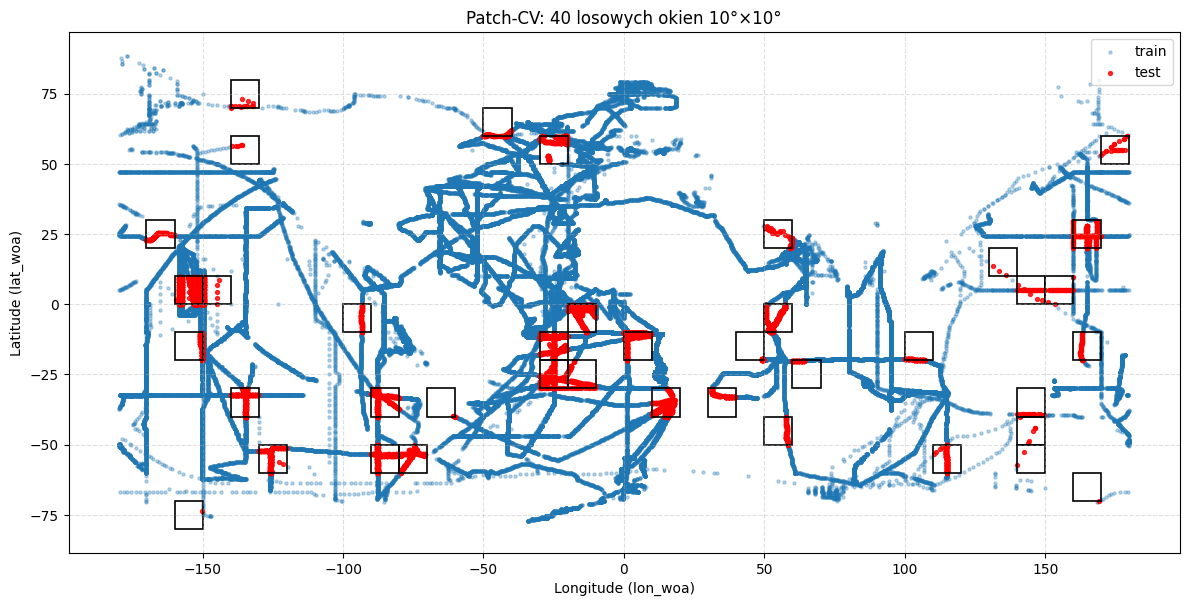

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(12, 6))

# Punkty treningowe (nie w patchach)
ax.scatter(df_result.loc[~global_test_mask, "lon_woa"],
           df_result.loc[~global_test_mask, "lat_woa"],
           s=5, alpha=0.3, label="train")

# Punkty testowe (w patchach)
ax.scatter(df_result.loc[global_test_mask, "lon_woa"],
           df_result.loc[global_test_mask, "lat_woa"],
           s=8, alpha=0.8, color="red", label="test")

for la0, la1, lo0, lo1 in patch_list:
    ax.add_patch(Rectangle((lo0, la0),
                           lo1 - lo0,
                           la1 - la0,
                           fill=False,
                           edgecolor="black",
                           linewidth=1.2))

ax.set(title="Patch-CV: 40 losowych okien 10°×10°",
       xlabel="Longitude (lon_woa)",
       ylabel="Latitude (lat_woa)")
ax.legend(loc="upper right")
ax.set_aspect("equal", adjustable="box")
ax.grid(ls="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [9]:
df_train = df_result.loc[~global_test_mask].copy()
df_test = df_result.loc[global_test_mask].copy()


target_col = 'dn2o_ppb'

X_train = df_train.drop(columns=[target_col])
X_test = df_test.drop(columns=[target_col])
print(f"Train size: {len(df_train)}")
print(f"Test size: {len(df_test)}")

Train size: 114620
Test size: 13888


In [10]:
target_col = 'dn2o_ppb'
y_train = df_train[target_col]
y_test = df_test[target_col]

In [14]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

N_JOBS = -1
SEED = 42

xgb = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    reg_lambda=1.0,
    device='cuda',
    n_jobs=N_JOBS,
    random_state=SEED,
)

def evaluate(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name:<18} MSE={mse:.4f} RMSE={rmse:.4f} MAE={mae:.4f}  R2={r2:.4f}")


xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
evaluate("XGBoost", y_test, pred_xgb)

XGBoost            MSE=559.4864 RMSE=23.6535 MAE=14.3104  R2=0.0815


In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Xy_train = X_train.copy()
Xy_train["target"] = y_train
Xy_train = Xy_train.dropna()

X_train_clean = Xy_train.drop("target", axis=1)
y_train_clean = Xy_train["target"]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(X_train_clean)
X_test_scaled = feature_scaler.transform(X_test)

target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train_clean.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

X_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

val_ratio = 0.2
n_total = len(X_tensor)
n_val = int(val_ratio * n_total)
n_train = n_total - n_val

train_ds, val_ds = random_split(TensorDataset(X_tensor, y_tensor), [n_train, n_val])
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)

class DNNRegressor(nn.Module):
    def __init__(self, input_dim):
        super(DNNRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

model = DNNRegressor(X_train_clean.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 100
patience = 10
best_val_mse = float("inf")
epochs_no_improve = 0
best_model_state = None

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_losses = []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_preds = []
        val_targets = []
        for xb, yb in val_loader:
            xb = xb.to(device)
            pred = model(xb).cpu().numpy()
            val_preds.append(pred)
            val_targets.append(yb.numpy())

        val_preds = np.concatenate(val_preds).flatten()
        val_targets = np.concatenate(val_targets).flatten()

        val_mse = mean_squared_error(val_targets, val_preds)
        val_r2 = r2_score(val_targets, val_preds)
        val_rmse = np.sqrt(val_mse)
        val_mae = mean_absolute_error(val_targets, val_preds)

    print(f"Epoch {epoch:03d}: TrainLoss={np.mean(train_losses):.4f} ValMSE={val_mse:.4f} RMSE={val_rmse:.4f} MAE={val_mae:.4f} R2={val_r2:.4f}")

    if val_mse < best_val_mse:
        best_val_mse = val_mse
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch} (no improvement for {patience} epochs).")
            break

model.load_state_dict(best_model_state)
model.eval()

with torch.no_grad():
    final_preds_scaled = model(X_test_tensor.to(device)).cpu().numpy()
    final_preds = target_scaler.inverse_transform(final_preds_scaled).flatten()
    y_test_true = target_scaler.inverse_transform(y_test_tensor.numpy()).flatten()

def evaluate(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name:<18} MSE={mse:.4f} RMSE={rmse:.4f} MAE={mae:.4f}  R2={r2:.4f}")

print(f"\ny_test std deviation: {y_test.std():.4f}")
evaluate("DNN Regressor", y_test_true, final_preds)


Epoch 001: TrainLoss=0.7393 ValMSE=0.7211 RMSE=0.8492 MAE=0.1217 R2=0.2850
Epoch 002: TrainLoss=0.6936 ValMSE=0.6935 RMSE=0.8328 MAE=0.1112 R2=0.3124
Epoch 003: TrainLoss=0.6749 ValMSE=0.6573 RMSE=0.8107 MAE=0.1043 R2=0.3483
Epoch 004: TrainLoss=0.6568 ValMSE=0.6267 RMSE=0.7916 MAE=0.1062 R2=0.3787
Epoch 005: TrainLoss=0.6379 ValMSE=0.6536 RMSE=0.8085 MAE=0.1016 R2=0.3519
Epoch 006: TrainLoss=0.6271 ValMSE=0.7065 RMSE=0.8405 MAE=0.1060 R2=0.2996
Epoch 007: TrainLoss=0.6386 ValMSE=0.6644 RMSE=0.8151 MAE=0.0955 R2=0.3413
Epoch 008: TrainLoss=0.6243 ValMSE=0.6157 RMSE=0.7847 MAE=0.0906 R2=0.3895
Epoch 009: TrainLoss=0.6052 ValMSE=0.6789 RMSE=0.8239 MAE=0.1003 R2=0.3269
Epoch 010: TrainLoss=0.6441 ValMSE=0.6210 RMSE=0.7881 MAE=0.0946 R2=0.3843
Epoch 011: TrainLoss=0.6517 ValMSE=0.7204 RMSE=0.8487 MAE=0.1022 R2=0.2858
Epoch 012: TrainLoss=0.6160 ValMSE=0.5830 RMSE=0.7635 MAE=0.0994 R2=0.4220
Epoch 013: TrainLoss=0.6056 ValMSE=0.6709 RMSE=0.8191 MAE=0.1015 R2=0.3348
Epoch 014: TrainLoss=0.59

In [25]:
pip install pytorch_tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [28]:
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pytorch_tabnet.tab_model import TabNetRegressor

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Clean and scale data
Xy = X_train.copy(); Xy["target"] = y_train; Xy = Xy.dropna()
X_train_clean = Xy.drop("target", axis=1); y_train_clean = Xy["target"]
X_test_clean = X_test.dropna()
y_test_clean = y_test.loc[X_test_clean.index]

scaler_X = StandardScaler().fit(X_train_clean)
scaler_y = StandardScaler().fit(y_train_clean.values.reshape(-1,1))
X_train_scaled = scaler_X.transform(X_train_clean)
X_test_scaled = scaler_X.transform(X_test_clean)
y_train_scaled = scaler_y.transform(y_train_clean.values.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test_clean.values.reshape(-1,1))

n_total = len(X_train_scaled)
n_val = int(n_total * 0.2)
X_tr, X_val = X_train_scaled[:-n_val], X_train_scaled[-n_val:]
y_tr, y_val = y_train_scaled[:-n_val], y_train_scaled[-n_val:]

tabnet = TabNetRegressor(
    n_d=16, n_a=16, n_steps=5,
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=0.0002, weight_decay=1e-5),
    scheduler_params=dict(step_size=50, gamma=0.9),
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type="sparsemax",
    verbose=10,
    seed=SEED,
)

tabnet.fit(
    X_train=X_tr, y_train=y_tr,
    eval_set=[(X_val, y_val)],
    eval_name=["val"],
    eval_metric=["rmse"],
    max_epochs=200,
    patience=20,
    batch_size=64,
    virtual_batch_size=64,
)

preds_scaled = tabnet.predict(X_test_scaled)
preds = scaler_y.inverse_transform(preds_scaled.reshape(-1,1)).flatten()
y_true = y_test_clean.values

mse = mean_squared_error(y_true, preds)
rmse = np.sqrt(mse); mae = mean_absolute_error(y_true, preds)
r2 = r2_score(y_true, preds)

print(f"Final Results — MSE={mse:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4.26405 | val_rmse: 1.86858 |  0:00:54s
epoch 10 | loss: 0.94389 | val_rmse: 0.61806 |  0:09:29s
epoch 20 | loss: 0.87775 | val_rmse: 0.39736 |  0:18:11s
epoch 30 | loss: 0.80022 | val_rmse: 0.39676 |  0:26:49s

Early stopping occurred at epoch 37 with best_epoch = 17 and best_val_rmse = 0.25503


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Final Results — MSE=1362.0523, RMSE=36.9060, MAE=21.0726, R2=-1.2362


# Zapisywanie datasetu (przyda się dla testowania czapeczki do regresji)

In [ ]:
df_result.to_csv('yang_woa_grid_shallow_neighbors.csv', index=False)

# Dataset dla MAE - patche

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

df_woa = pd.read_csv('woa_grid_shallow.csv').dropna()

GRID_STEP = 0.25
TOLERANCE = 0.001

features = [col for col in df_woa.columns]
num_features = len(features)
print(f"Znaleziono {num_features} cech w danych")

coord_dict = {}
for idx, row in tqdm(df_woa.iterrows(), total=len(df_woa), desc="Indeksowanie punktów"):
    lat_key = round(row['lat'] / TOLERANCE) * TOLERANCE
    lon_key = round(row['lon'] / TOLERANCE) * TOLERANCE
    coord_dict[(lat_key, lon_key)] = row[features].values

print("\nObliczanie unikalnych pozycji centralnych")
unique_coords = df_woa[['lat', 'lon']].drop_duplicates()
unique_coords['lat'] = round(unique_coords['lat'] / GRID_STEP) * GRID_STEP
unique_coords['lon'] = round(unique_coords['lon'] / GRID_STEP) * GRID_STEP
unique_coords = unique_coords.drop_duplicates()

print("\nGenerowanie patchy 3x3")
patches = []
valid_coords = []
missing_counts = np.zeros((3, 3))

for _, row in tqdm(unique_coords.iterrows(), total=len(unique_coords), desc="Tworzenie patchy"):
    center_lat = row['lat']
    center_lon = row['lon']

    patch_data = np.zeros((3, 3, num_features))
    valid_patch = True

    for i, dlat in enumerate([-GRID_STEP, 0, GRID_STEP]):
        for j, dlon in enumerate([-GRID_STEP, 0, GRID_STEP]):
            lat = center_lat + dlat
            lon = center_lon + dlon

            lat_key = round(lat / TOLERANCE) * TOLERANCE
            lon_key = round(lon / TOLERANCE) * TOLERANCE

            if (lat_key, lon_key) in coord_dict:
                patch_data[i, j] = coord_dict[(lat_key, lon_key)]
            else:
                missing_counts[i, j] += 1
                valid_patch = False

    if valid_patch:
        patches.append(patch_data)
        valid_coords.append((center_lat, center_lon))

patch_array = np.array(patches)
print(f"\nUtworzono {len(patches)} patchy")
print(f"Kształt danych: {patch_array.shape} (patche × 3 × 3 × cechy)")

print("\nStatystyki brakujących punktów w siatce 3x3:")
position_names = [
    ['lewy-górny', 'górny', 'prawy-górny'],
    ['lewy', 'centralny', 'prawy'],
    ['lewy-dolny', 'dolny', 'prawy-dolny']
]
for i in range(3):
    for j in range(3):
        print(f"Pozycja {position_names[i][j]}: brakuje {int(missing_counts[i,j])} punktów")

np.save('woa_3x3_patches.npy', patch_array)

coord_df = pd.DataFrame(valid_coords, columns=['center_lat', 'center_lon'])
coord_df.to_csv('patch_centers.csv', index=False)


Znaleziono 8 cech w danych


Indeksowanie punktów: 100%|██████████| 961353/961353 [05:28<00:00, 2928.93it/s]



Obliczanie unikalnych pozycji centralnych

Generowanie patchy 3x3


Tworzenie patchy: 100%|██████████| 961353/961353 [01:17<00:00, 12472.43it/s]



Utworzono 957145 patchy
Kształt danych: (957145, 3, 3, 8) (patche × 3 × 3 × cechy)

Statystyki brakujących punktów w siatce 3x3:
Pozycja lewy-górny: brakuje 2105 punktów
Pozycja górny: brakuje 1437 punktów
Pozycja prawy-górny: brakuje 2105 punktów
Pozycja lewy: brakuje 669 punktów
Pozycja centralny: brakuje 0 punktów
Pozycja prawy: brakuje 669 punktów
Pozycja lewy-dolny: brakuje 2105 punktów
Pozycja dolny: brakuje 1437 punktów
Pozycja prawy-dolny: brakuje 2105 punktów


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from tqdm import tqdm
import math


patches = np.load('woa_3x3_patches.npy')  # Shape: (N, 3, 3, C)
valid = ~np.isnan(patches).any(axis=(1, 2, 3))  # Remove samples with NaNs
patches = patches[valid]


mean = patches.mean(axis=(0, 1, 2), keepdims=True)
std = patches.std(axis=(0, 1, 2), keepdims=True) + 1e-8
patches = (patches - mean) / std


data_tensor = torch.tensor(patches, dtype=torch.float32)  # (N, 3, 3, C)


train_size = int(0.8 * len(data_tensor))
val_size = len(data_tensor) - train_size
train_data, val_data = random_split(data_tensor, [train_size, val_size])


train_loader = DataLoader(train_data, batch_size=512, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=1024, shuffle=False, num_workers=2, pin_memory=True)


class ResidualAttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, 3, padding=1)
        self.norm = nn.BatchNorm2d(channels)
        self.attn = nn.MultiheadAttention(channels, num_heads=4, batch_first=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        x = self.relu(self.norm(self.conv(x)))
        B, C, H, W = x.shape
        x_flat = x.view(B, C, -1).transpose(1, 2)  # (B, H*W, C)
        attn_out, _ = self.attn(x_flat, x_flat, x_flat)
        attn_out = attn_out.transpose(1, 2).view(B, C, H, W)
        return residual + attn_out

class OceanMAE(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.mask_ratio = 0.4

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1),
            nn.ReLU(),
            ResidualAttentionBlock(64),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            ResidualAttentionBlock(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, in_channels, 3, padding=1),
        )

    def forward(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(0)
        B, H, W, C = x.shape
        x = x.permute(0, 3, 1, 2)  # (B, C, H, W)

        mask = (torch.rand(B, 1, H, W, device=x.device) > self.mask_ratio).float()
        masked_x = x * mask

        encoded = self.encoder(masked_x)
        decoded = self.decoder(encoded)

        return decoded, x, mask

class MaskedMSELoss(nn.Module):
    def forward(self, pred, target, mask):
        loss = (pred - target) ** 2
        masked_loss = (loss * mask).sum() / (mask.sum() + 1e-8)
        full_loss = loss.mean()
        return masked_loss, full_loss


def train_one_epoch(model, loader, optimizer, device, scaler, epoch, total_epochs):
    model.train()
    masked_total, full_total = 0.0, 0.0
    for batch in tqdm(loader, desc="Train", leave=False):
        inputs = batch.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            pred, target, mask = model(inputs)
            masked_loss, full_loss = criterion(pred, target, mask)
            alpha = max(0.1 * (1 - epoch / total_epochs), 0.01)
            loss = masked_loss + alpha * full_loss

        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        masked_total += masked_loss.item()
        full_total += full_loss.item()

    return masked_total / len(loader), full_total / len(loader)

def validate(model, loader, device):
    model.eval()
    masked_total, full_total = 0.0, 0.0
    with torch.no_grad():
        for batch in tqdm(loader, desc="Valid", leave=False):
            inputs = batch.to(device)
            pred, target, mask = model(inputs)
            masked_loss, full_loss = criterion(pred, target, mask)
            masked_total += masked_loss.item()
            full_total += full_loss.item()

    return masked_total / len(loader), full_total / len(loader)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OceanMAE(in_channels=patches.shape[-1]).to(device)
criterion = MaskedMSELoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
scaler = torch.cuda.amp.GradScaler()

best_val = float('inf')
patience, no_improve = 10, 0
epochs = 50


print("Starting training...")
for epoch in range(epochs):

    model.mask_ratio = 0.3 + 0.3 * 0.5 * (1 - math.cos(math.pi * (epoch % 10) / 10))

    train_m, train_f = train_one_epoch(model, train_loader, optimizer, device, scaler, epoch, epochs)
    val_m, val_f = validate(model, val_loader, device)
    scheduler.step()

    print(f"Epoch {epoch+1:03d}/{epochs}:")
    print(f"  Train - Masked Loss: {train_m:.5f} | Full Loss: {train_f:.5f}")
    print(f"  Val   - Masked Loss: {val_m:.5f} | Full Loss: {val_f:.5f}")
    print(f"  Mask Ratio: {model.mask_ratio:.2f} | LR: {optimizer.param_groups[0]['lr']:.2e}")
    print("-" * 60)

    if val_f < best_val:
        best_val = val_f
        no_improve = 0
        torch.save(model.state_dict(), "best_ocean_mae.pth")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

print("Loading best model and saving final weights...")
model.load_state_dict(torch.load("best_ocean_mae.pth"))
torch.save(model.state_dict(), "final_ocean_mae.pth")
print("Done.")


<ipython-input-14-3763017784>:135: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Starting training...


Train:   0%|          | 0/1496 [00:00<?, ?it/s]<ipython-input-14-3763017784>:100: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 001/50:
  Train - Masked Loss: 0.18034 | Full Loss: 0.02327
  Val   - Masked Loss: 0.02458 | Full Loss: 0.00332
  Mask Ratio: 0.30 | LR: 5.00e-04
------------------------------------------------------------


Epoch 002/50:
  Train - Masked Loss: 0.02018 | Full Loss: 0.00286
  Val   - Masked Loss: 0.01327 | Full Loss: 0.00194
  Mask Ratio: 0.31 | LR: 4.98e-04
------------------------------------------------------------


Epoch 003/50:
  Train - Masked Loss: 0.01391 | Full Loss: 0.00206
  Val   - Masked Loss: 0.00925 | Full Loss: 0.00141
  Mask Ratio: 0.33 | LR: 4.96e-04
------------------------------------------------------------


Epoch 004/50:
  Train - Masked Loss: 0.01085 | Full Loss: 0.00176
  Val   - Masked Loss: 0.01000 | Full Loss: 0.00152
  Mask Ratio: 0.36 | LR: 4.92e-04
------------------------------------------------------------


Epoch 005/50:
  Train - Masked Loss: 0.00908 | Full Loss: 0.00172
  Val   - Masked Loss: 0.01275 | Full Loss: 0.00199
  Mask Ratio: 0.40 | LR: 4.88e-04
------------------------------------------------------------


Epoch 006/50:
  Train - Masked Loss: 0.00863 | Full Loss: 0.00218
  Val   - Masked Loss: 0.00784 | Full Loss: 0.00204
  Mask Ratio: 0.45 | LR: 4.82e-04
------------------------------------------------------------


Epoch 007/50:
  Train - Masked Loss: 0.00946 | Full Loss: 0.00318
  Val   - Masked Loss: 0.00867 | Full Loss: 0.00311
  Mask Ratio: 0.50 | LR: 4.76e-04
------------------------------------------------------------


Epoch 008/50:
  Train - Masked Loss: 0.00826 | Full Loss: 0.00481
  Val   - Masked Loss: 0.00571 | Full Loss: 0.00462
  Mask Ratio: 0.54 | LR: 4.69e-04
------------------------------------------------------------


Epoch 009/50:
  Train - Masked Loss: 0.00777 | Full Loss: 0.00712
  Val   - Masked Loss: 0.00870 | Full Loss: 0.00723
  Mask Ratio: 0.57 | LR: 4.61e-04
------------------------------------------------------------


Epoch 010/50:
  Train - Masked Loss: 0.00757 | Full Loss: 0.00939
  Val   - Masked Loss: 0.00586 | Full Loss: 0.00877
  Mask Ratio: 0.59 | LR: 4.52e-04
------------------------------------------------------------


Epoch 011/50:
  Train - Masked Loss: 0.00818 | Full Loss: 0.00118
  Val   - Masked Loss: 0.00555 | Full Loss: 0.00081
  Mask Ratio: 0.30 | LR: 4.43e-04
------------------------------------------------------------


Epoch 012/50:
  Train - Masked Loss: 0.00554 | Full Loss: 0.00084
  Val   - Masked Loss: 0.00429 | Full Loss: 0.00068
  Mask Ratio: 0.31 | LR: 4.32e-04
------------------------------------------------------------


Epoch 013/50:
  Train - Masked Loss: 0.00499 | Full Loss: 0.00082
  Val   - Masked Loss: 0.00448 | Full Loss: 0.00071
  Mask Ratio: 0.33 | LR: 4.21e-04
------------------------------------------------------------


Epoch 014/50:
  Train - Masked Loss: 0.00468 | Full Loss: 0.00088
  Val   - Masked Loss: 0.00424 | Full Loss: 0.00088
  Mask Ratio: 0.36 | LR: 4.09e-04
------------------------------------------------------------


Epoch 015/50:
  Train - Masked Loss: 0.00449 | Full Loss: 0.00106
  Val   - Masked Loss: 0.00412 | Full Loss: 0.00094
  Mask Ratio: 0.40 | LR: 3.97e-04
------------------------------------------------------------


Epoch 016/50:
  Train - Masked Loss: 0.00510 | Full Loss: 0.00159
  Val   - Masked Loss: 0.00461 | Full Loss: 0.00136
  Mask Ratio: 0.45 | LR: 3.84e-04
------------------------------------------------------------


Epoch 017/50:
  Train - Masked Loss: 0.00518 | Full Loss: 0.00268
  Val   - Masked Loss: 0.00446 | Full Loss: 0.00254
  Mask Ratio: 0.50 | LR: 3.70e-04
------------------------------------------------------------


Epoch 018/50:
  Train - Masked Loss: 0.00519 | Full Loss: 0.00421
  Val   - Masked Loss: 0.00415 | Full Loss: 0.00453
  Mask Ratio: 0.54 | LR: 3.56e-04
------------------------------------------------------------


Epoch 019/50:
  Train - Masked Loss: 0.00517 | Full Loss: 0.00706
  Val   - Masked Loss: 0.00445 | Full Loss: 0.00657
  Mask Ratio: 0.57 | LR: 3.42e-04
------------------------------------------------------------


Epoch 020/50:
  Train - Masked Loss: 0.00490 | Full Loss: 0.00909
  Val   - Masked Loss: 0.00392 | Full Loss: 0.00905
  Mask Ratio: 0.59 | LR: 3.27e-04
------------------------------------------------------------


Epoch 021/50:
  Train - Masked Loss: 0.00518 | Full Loss: 0.00080
  Val   - Masked Loss: 0.00451 | Full Loss: 0.00070
  Mask Ratio: 0.30 | LR: 3.12e-04
------------------------------------------------------------


Epoch 022/50:
  Train - Masked Loss: 0.00378 | Full Loss: 0.00062
  Val   - Masked Loss: 0.00356 | Full Loss: 0.00061
  Mask Ratio: 0.31 | LR: 2.97e-04
------------------------------------------------------------


Epoch 023/50:
  Train - Masked Loss: 0.00359 | Full Loss: 0.00063
  Val   - Masked Loss: 0.00299 | Full Loss: 0.00053
  Mask Ratio: 0.33 | LR: 2.81e-04
------------------------------------------------------------


Epoch 024/50:
  Train - Masked Loss: 0.00347 | Full Loss: 0.00070
  Val   - Masked Loss: 0.00315 | Full Loss: 0.00062
  Mask Ratio: 0.36 | LR: 2.66e-04
------------------------------------------------------------


Epoch 025/50:
  Train - Masked Loss: 0.00357 | Full Loss: 0.00095
  Val   - Masked Loss: 0.00318 | Full Loss: 0.00083
  Mask Ratio: 0.40 | LR: 2.50e-04
------------------------------------------------------------


Epoch 026/50:
  Train - Masked Loss: 0.00369 | Full Loss: 0.00148
  Val   - Masked Loss: 0.00344 | Full Loss: 0.00145
  Mask Ratio: 0.45 | LR: 2.34e-04
------------------------------------------------------------


Epoch 027/50:
  Train - Masked Loss: 0.00379 | Full Loss: 0.00247
  Val   - Masked Loss: 0.00338 | Full Loss: 0.00253
  Mask Ratio: 0.50 | LR: 2.19e-04
------------------------------------------------------------


Epoch 028/50:
  Train - Masked Loss: 0.00388 | Full Loss: 0.00428
  Val   - Masked Loss: 0.00352 | Full Loss: 0.00437
  Mask Ratio: 0.54 | LR: 2.03e-04
------------------------------------------------------------


Epoch 029/50:
  Train - Masked Loss: 0.00394 | Full Loss: 0.00670
  Val   - Masked Loss: 0.00337 | Full Loss: 0.00660
  Mask Ratio: 0.57 | LR: 1.88e-04
------------------------------------------------------------


Epoch 030/50:
  Train - Masked Loss: 0.00392 | Full Loss: 0.00910
  Val   - Masked Loss: 0.00354 | Full Loss: 0.00894
  Mask Ratio: 0.59 | LR: 1.73e-04
------------------------------------------------------------


Epoch 031/50:
  Train - Masked Loss: 0.00414 | Full Loss: 0.00066
  Val   - Masked Loss: 0.00311 | Full Loss: 0.00051
  Mask Ratio: 0.30 | LR: 1.58e-04
------------------------------------------------------------


Epoch 032/50:
  Train - Masked Loss: 0.00312 | Full Loss: 0.00054
  Val   - Masked Loss: 0.00303 | Full Loss: 0.00051
  Mask Ratio: 0.31 | LR: 1.44e-04
------------------------------------------------------------


Epoch 033/50:
  Train - Masked Loss: 0.00303 | Full Loss: 0.00057
  Val   - Masked Loss: 0.00269 | Full Loss: 0.00050
  Mask Ratio: 0.33 | LR: 1.30e-04
------------------------------------------------------------


Epoch 034/50:
  Train - Masked Loss: 0.00301 | Full Loss: 0.00066
  Val   - Masked Loss: 0.00282 | Full Loss: 0.00062
  Mask Ratio: 0.36 | LR: 1.16e-04
------------------------------------------------------------


Epoch 035/50:
  Train - Masked Loss: 0.00305 | Full Loss: 0.00091
  Val   - Masked Loss: 0.00293 | Full Loss: 0.00092
  Mask Ratio: 0.40 | LR: 1.03e-04
------------------------------------------------------------


Epoch 036/50:
  Train - Masked Loss: 0.00317 | Full Loss: 0.00150
  Val   - Masked Loss: 0.00286 | Full Loss: 0.00130
  Mask Ratio: 0.45 | LR: 9.06e-05
------------------------------------------------------------


Epoch 037/50:
  Train - Masked Loss: 0.00332 | Full Loss: 0.00248
  Val   - Masked Loss: 0.00304 | Full Loss: 0.00242
  Mask Ratio: 0.50 | LR: 7.89e-05
------------------------------------------------------------


Epoch 038/50:
  Train - Masked Loss: 0.00337 | Full Loss: 0.00430
  Val   - Masked Loss: 0.00301 | Full Loss: 0.00426
  Mask Ratio: 0.54 | LR: 6.78e-05
------------------------------------------------------------


Epoch 039/50:
  Train - Masked Loss: 0.00351 | Full Loss: 0.00680
  Val   - Masked Loss: 0.00306 | Full Loss: 0.00646
  Mask Ratio: 0.57 | LR: 5.74e-05
------------------------------------------------------------


Epoch 040/50:
  Train - Masked Loss: 0.00355 | Full Loss: 0.00923
  Val   - Masked Loss: 0.00318 | Full Loss: 0.00880
  Mask Ratio: 0.59 | LR: 4.77e-05
------------------------------------------------------------


Epoch 041/50:
  Train - Masked Loss: 0.00382 | Full Loss: 0.00064
  Val   - Masked Loss: 0.00263 | Full Loss: 0.00044
  Mask Ratio: 0.30 | LR: 3.89e-05
------------------------------------------------------------


Epoch 042/50:
  Train - Masked Loss: 0.00278 | Full Loss: 0.00050
  Val   - Masked Loss: 0.00256 | Full Loss: 0.00045
  Mask Ratio: 0.31 | LR: 3.09e-05
------------------------------------------------------------


Epoch 043/50:
  Train - Masked Loss: 0.00276 | Full Loss: 0.00053
  Val   - Masked Loss: 0.00255 | Full Loss: 0.00049
  Mask Ratio: 0.33 | LR: 2.38e-05
------------------------------------------------------------


Epoch 044/50:
  Train - Masked Loss: 0.00279 | Full Loss: 0.00064
  Val   - Masked Loss: 0.00259 | Full Loss: 0.00060
  Mask Ratio: 0.36 | LR: 1.76e-05
------------------------------------------------------------


Epoch 045/50:
  Train - Masked Loss: 0.00287 | Full Loss: 0.00088
  Val   - Masked Loss: 0.00262 | Full Loss: 0.00082
  Mask Ratio: 0.40 | LR: 1.22e-05
------------------------------------------------------------


Epoch 046/50:
  Train - Masked Loss: 0.00302 | Full Loss: 0.00148
  Val   - Masked Loss: 0.00274 | Full Loss: 0.00143
  Mask Ratio: 0.45 | LR: 7.85e-06
------------------------------------------------------------


Epoch 047/50:
  Train - Masked Loss: 0.00320 | Full Loss: 0.00259
  Val   - Masked Loss: 0.00284 | Full Loss: 0.00233
  Mask Ratio: 0.50 | LR: 4.43e-06
------------------------------------------------------------


Epoch 048/50:
  Train - Masked Loss: 0.00341 | Full Loss: 0.00464
  Val   - Masked Loss: 0.00298 | Full Loss: 0.00415
  Mask Ratio: 0.54 | LR: 1.97e-06
------------------------------------------------------------


Epoch 049/50:
  Train - Masked Loss: 0.00364 | Full Loss: 0.00724
  Val   - Masked Loss: 0.00315 | Full Loss: 0.00694
  Mask Ratio: 0.57 | LR: 4.93e-07
------------------------------------------------------------


Epoch 050/50:
  Train - Masked Loss: 0.00384 | Full Loss: 0.00956
  Val   - Masked Loss: 0.00330 | Full Loss: 0.00901
  Mask Ratio: 0.59 | LR: 0.00e+00
------------------------------------------------------------
Loading best model and saving final weights...
Done.


Index(['dn2o_ppb', 'lat_woa', 'lon_woa', 'temperature_00', 'salinity_00',
       'oxygen_00', 'nitrate_00', 'phosphate_00', 'depth_woa', 'neigh_1_lat',
       'neigh_1_lon', 'neigh_1_temperature_00', 'neigh_1_salinity_00',
       'neigh_1_oxygen_00', 'neigh_1_nitrate_00', 'neigh_1_phosphate_00',
       'neigh_1_depth', 'neigh_2_lat', 'neigh_2_lon', 'neigh_2_temperature_00',
       'neigh_2_salinity_00', 'neigh_2_oxygen_00', 'neigh_2_nitrate_00',
       'neigh_2_phosphate_00', 'neigh_2_depth', 'neigh_3_lat', 'neigh_3_lon',
       'neigh_3_temperature_00', 'neigh_3_salinity_00', 'neigh_3_oxygen_00',
       'neigh_3_nitrate_00', 'neigh_3_phosphate_00', 'neigh_3_depth',
       'neigh_4_lat', 'neigh_4_lon', 'neigh_4_temperature_00',
       'neigh_4_salinity_00', 'neigh_4_oxygen_00', 'neigh_4_nitrate_00',
       'neigh_4_phosphate_00', 'neigh_4_depth', 'neigh_5_lat', 'neigh_5_lon',
       'neigh_5_temperature_00', 'neigh_5_salinity_00', 'neigh_5_oxygen_00',
       'neigh_5_nitrate_00', 'neig

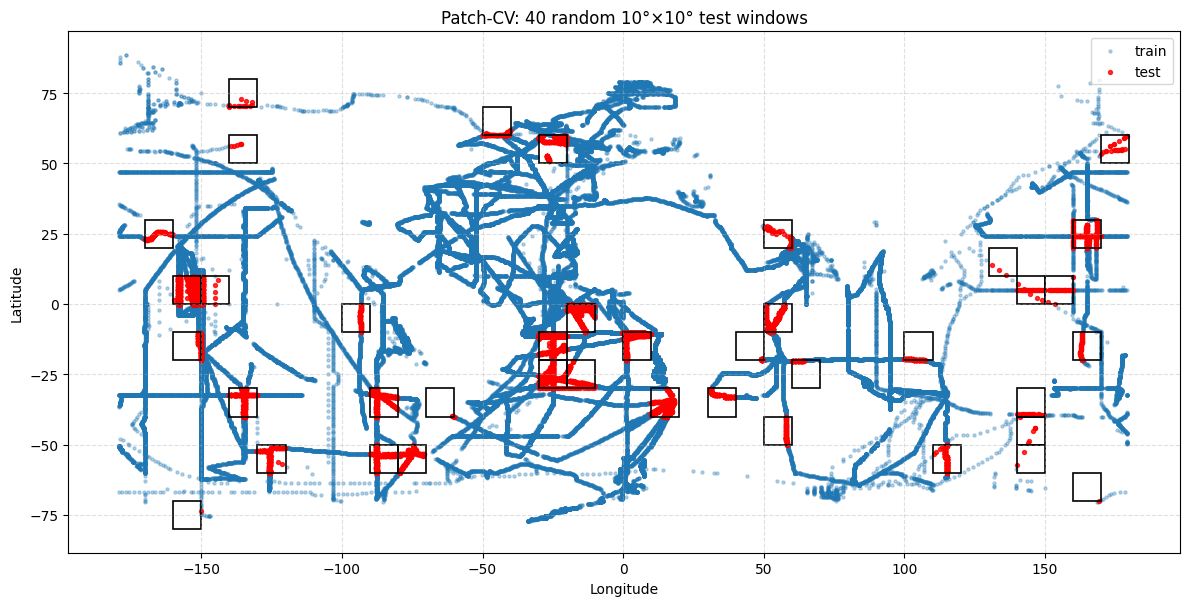

Creating patches: 100%|██████████| 128299/128299 [06:17<00:00, 340.12it/s]


Patches shape: (128299, 3, 3, 8)


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def random_geo_patches(df, lat_col='lat', lon_col='lon',
                       patch_deg=10, n_patches=40, seed=42):
    rng = np.random.RandomState(seed)

    lat_min, lat_max = df[lat_col].min(), df[lat_col].max()
    lon_min, lon_max = df[lon_col].min(), df[lon_col].max()

    lat_bins = np.arange(np.floor(lat_min / patch_deg) * patch_deg,
                         np.ceil(lat_max / patch_deg) * patch_deg + patch_deg,
                         patch_deg)
    lon_bins = np.arange(np.floor(lon_min / patch_deg) * patch_deg,
                         np.ceil(lon_max / patch_deg) * patch_deg + patch_deg,
                         patch_deg)

    grid = [(lat_bins[i], lat_bins[i]+patch_deg,
             lon_bins[j], lon_bins[j]+patch_deg)
            for i in range(len(lat_bins)-1)
            for j in range(len(lon_bins)-1)]

    rng.shuffle(grid)

    selected = []
    mask = np.zeros(len(df), dtype=bool)
    for bbox in grid:
        if len(selected) >= n_patches:
            break
        la0, la1, lo0, lo1 = bbox
        inside = (
            df[lat_col].between(la0, la1, inclusive="left") &
            df[lon_col].between(lo0, lo1, inclusive="left")
        )
        if inside.any():
            selected.append(bbox)
            mask |= inside

    return selected, mask



df = pd.read_csv('yang_woa_grid_shallow_neighbors.csv').dropna()
print(df.columns)

lat_min, lat_max = df['lat_woa'].min(), df['lat_woa'].max()
lon_min, lon_max = df['lon_woa'].min(), df['lon_woa'].max()

# Center lat/lon
#df['lat'] = (df['lat_woa'] - lat_min) / (lat_max - lat_min)
#df['lon'] = (df['lon_woa'] - lon_min) / (lon_max - lon_min)
df['lat'] = df['lat_woa']
df['lon'] = df['lon_woa']
# Normalize neighbor lat/lon similarly
#for i in range(1, 9):
#    df[f'neigh_{i}_lat'] = (df[f'neigh_{i}_lat'] - lat_min) / (lat_max - lat_min)
#    df[f'neigh_{i}_lon'] = (df[f'neigh_{i}_lon'] - lon_min) / (lon_max - lon_min)


for i in range(1, 9):
    df[f'neigh_{i}_lat'] = df[f'neigh_{i}_lat'] - lat_min
    df[f'neigh_{i}_lon'] = df[f'neigh_{i}_lon'] - lon_min


patch_list, global_test_mask = random_geo_patches(
    df, lat_col='lat_woa', lon_col='lon_woa', patch_deg=10, n_patches=40, seed=42
)
print(f"Train: {(~global_test_mask).sum():,d}  |  Test: {global_test_mask.sum():,d} "
      f"({global_test_mask.mean():.2%} of total) in {len(patch_list)} patches")


fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(df.loc[~global_test_mask, "lon_woa"], df.loc[~global_test_mask, "lat_woa"],
           s=5, alpha=0.3, label="train")
ax.scatter(df.loc[global_test_mask, "lon_woa"], df.loc[global_test_mask, "lat_woa"],
           s=8, alpha=0.8, color="red", label="test")
for la0, la1, lo0, lo1 in patch_list:
    ax.add_patch(Rectangle((lo0, la0), lo1 - lo0, la1 - la0,
                           fill=False, edgecolor="black", linewidth=1.2))
ax.set(title="Patch-CV: 40 random 10°×10° test windows",
       xlabel="Longitude", ylabel="Latitude")
ax.legend(loc="upper right")
ax.set_aspect("equal", adjustable="box")
ax.grid(ls="--", alpha=0.4)
plt.tight_layout()
plt.show()


base_cols = ['lat', 'lon', 'temperature_00', 'salinity_00', 'oxygen_00', 'nitrate_00', 'phosphate_00', 'depth']
prefix_order = [
    'neigh_1_', 'neigh_2_', 'neigh_3_',
    'neigh_4_', '',         'neigh_5_',
    'neigh_6_', 'neigh_7_', 'neigh_8_'
]

neigh_cols = []
for prefix in prefix_order:
    if prefix == '':
        cols = [col if col != 'depth' else 'depth_woa' for col in base_cols]
    else:
        cols = [f'{prefix}{col}' for col in base_cols]
    neigh_cols.append(cols)


patches = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Creating patches"):
    patch = np.zeros((3, 3, len(base_cols)))
    for i in range(9):
        r, c = divmod(i, 3)
        patch[r, c] = row[neigh_cols[i]]
    patches.append(patch)
patches = np.array(patches)
print(f"Patches shape: {patches.shape}")  # Should be (N, 3, 3, 8)

# === Normalize patches using training stats ===
#train_patches = np.load('woa_3x3_patches.npy')
#mean = train_patches.mean(axis=(0,1,2), keepdims=True)
#std = train_patches.std(axis=(0,1,2), keepdims=True) + 1e-8
#patches_norm = (patches - mean) / std

mean = patches.mean(axis=(0, 1, 2), keepdims=True)
std = patches.std(axis=(0, 1, 2), keepdims=True) + 1e-8
patches_norm = (patches - mean) / std


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
import numpy as np

def seed_everything(seed=42):
    import random, os
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = OceanMAE(in_channels=patches_norm.shape[-1]).to(device)
model.load_state_dict(torch.load('final_ocean_mae.pth', map_location=device))
model.eval()

raw_targets_np = df['dn2o_ppb'].values
global_test_mask_np = global_test_mask.values
valid_mask = (~np.isnan(raw_targets_np)) & (raw_targets_np >= 0)

filtered_patches_norm = patches_norm[valid_mask]
filtered_targets = raw_targets_np[valid_mask]
filtered_global_test_mask = global_test_mask_np[valid_mask]

with torch.no_grad():
    x = torch.tensor(filtered_patches_norm, dtype=torch.float32).to(device)
    x = x.permute(0, 3, 1, 2)  # from (N, H, W, C) to (N, C, H, W)
    features = model.encoder(x)
    embeddings = features.mean(dim=(2, 3)).cpu()

embeddings_np = embeddings.numpy()

# 4. Log scale the targets (log1p)
targets_np = np.log1p(filtered_targets)

embeddings_filtered = torch.tensor(embeddings_np, dtype=torch.float32)
targets_filtered = torch.tensor(targets_np, dtype=torch.float32).unsqueeze(1)

X_train = embeddings_filtered[~filtered_global_test_mask]
y_train = targets_filtered[~filtered_global_test_mask]
X_test = embeddings_filtered[filtered_global_test_mask]
y_test = targets_filtered[filtered_global_test_mask]

train_size = int(0.8 * len(X_train))
val_size = len(X_train) - train_size
train_ds, val_ds = random_split(TensorDataset(X_train, y_train), [train_size, val_size])

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

class SimpleNNRegressor(nn.Module):
    def __init__(self, in_dim, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

regressor = SimpleNNRegressor(X_train.shape[1], dropout=0.2).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(regressor.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)

best_val_rmse = float('inf')
early_stop_counter = 0
early_stop_patience = 20
max_grad_norm = 1.0

print("\nTraining regressor...")

for epoch in range(9):
    regressor.train()
    train_losses = []
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1:03d}", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = regressor(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(regressor.parameters(), max_grad_norm)
        optimizer.step()
        train_losses.append(loss.item())

    regressor.eval()
    val_true, val_pred = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = regressor(xb)
            val_true.append(yb.cpu())
            val_pred.append(preds.cpu())

    val_true = torch.cat(val_true).squeeze().numpy()
    val_pred = torch.cat(val_pred).squeeze().numpy()

    # Inverse transform predictions and true values back to original scale
    val_true_orig = np.expm1(val_true)
    val_pred_orig = np.expm1(val_pred)

    val_rmse_orig = mean_squared_error(val_true_orig, val_pred_orig)  # RMSE
    val_r2_orig = r2_score(val_true_orig, val_pred_orig)

    print(f"Epoch {epoch+1:03d} - Train Loss: {np.mean(train_losses):.4f} | Val RMSE (orig scale): {val_rmse_orig:.4f}, R² (orig scale): {val_r2_orig:.4f}")

    scheduler.step(val_rmse_orig)

    if val_rmse_orig < best_val_rmse:
        best_val_rmse = val_rmse_orig
        torch.save(regressor.state_dict(), 'best_regressor.pth')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

print("\nFinal evaluation on test set:")
regressor.load_state_dict(torch.load('best_regressor.pth'))
regressor.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = regressor(xb)
        y_true.append(yb.cpu())
        y_pred.append(preds.cpu())

y_true = torch.cat(y_true).squeeze().numpy()
y_pred = torch.cat(y_pred).squeeze().numpy()

# Inverse transform predictions and true values back to original scale
y_true_orig = np.expm1(y_true)
y_pred_orig = np.expm1(y_pred)

print(f"Test R² (orig scale): {r2_score(y_true_orig, y_pred_orig):.4f}")
print(f"Test RMSE (orig scale): {mean_squared_error(y_true_orig, y_pred_orig):.4f}")


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training regressor...


Epoch 001 - Train Loss: 1.0186 | Val RMSE (orig scale): 59955.0352, R² (orig scale): 0.2934


Epoch 002 - Train Loss: 0.5585 | Val RMSE (orig scale): 42655.0586, R² (orig scale): 0.4973


Epoch 003 - Train Loss: 0.5075 | Val RMSE (orig scale): 48791.8125, R² (orig scale): 0.4250


Epoch 004 - Train Loss: 0.4769 | Val RMSE (orig scale): 40232.7812, R² (orig scale): 0.5259


Epoch 005 - Train Loss: 0.4603 | Val RMSE (orig scale): 38320.5508, R² (orig scale): 0.5484


Epoch 006 - Train Loss: 0.4449 | Val RMSE (orig scale): 46154.8867, R² (orig scale): 0.4561


Epoch 007 - Train Loss: 0.4314 | Val RMSE (orig scale): 41113.4375, R² (orig scale): 0.5155


Epoch 008 - Train Loss: 0.4257 | Val RMSE (orig scale): 38766.5039, R² (orig scale): 0.5431


Epoch 009 - Train Loss: 0.4150 | Val RMSE (orig scale): 36615.7734, R² (orig scale): 0.5685

Final evaluation on test set:
Test R² (orig scale): 0.2067
Test RMSE (orig scale): 475.6656


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import numpy as np

def seed_everything(seed=42):
    import random, os
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OceanMAE(in_channels=patches.shape[-1]).to(device)
model.load_state_dict(torch.load('final_ocean_mae.pth', map_location=device))
model.eval()

with torch.no_grad():
    x = torch.tensor(patches_norm, dtype=torch.float32).to(device)
    x = x.permute(0, 3, 1, 2)
    features = model.encoder(x)
    embeddings = features.mean(dim=(2, 3)).cpu()

targets = torch.tensor(df['dn2o_ppb'].values, dtype=torch.float32).unsqueeze(1)

embeddings_np = embeddings.numpy()
targets_np = targets.numpy().squeeze()

not_nan_mask = (~np.isnan(embeddings_np).any(axis=1)) & (~np.isnan(targets_np))
embeddings_np = embeddings_np[not_nan_mask]
targets_np = targets_np[not_nan_mask]
global_test_mask_np = global_test_mask.values[not_nan_mask]

# Clip train/val targets to roughly match test range (CHEATING!!!! just for checking)
clip_min, clip_max = -150, 400

embeddings_filtered = torch.tensor(embeddings_np)
targets_filtered = torch.tensor(targets_np).unsqueeze(1)

X_train = embeddings_filtered[~global_test_mask_np]
y_train = targets_filtered[~global_test_mask_np]
X_test = embeddings_filtered[global_test_mask_np]
y_test = targets_filtered[global_test_mask_np]


y_train_clipped = torch.clamp(y_train, clip_min, clip_max)

train_size = int(0.8 * len(X_train))
val_size = len(X_train) - train_size
train_ds, val_ds = random_split(TensorDataset(X_train, y_train_clipped), [train_size, val_size])


batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

train_val_targets = torch.cat([y for _, y in train_ds] + [y for _, y in val_ds]).numpy().reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(train_val_targets)

def scale_targets(tensor):
    t_np = tensor.numpy().reshape(-1, 1)
    t_scaled = scaler.transform(t_np)
    return torch.tensor(t_scaled, dtype=torch.float32)

def inverse_scale_targets(np_array):
    return scaler.inverse_transform(np_array.reshape(-1,1)).flatten()


def scale_dataset(ds):
    xs = []
    ys = []
    for x, y in ds:
        xs.append(x)
        ys.append(y)
    xs = torch.stack(xs)
    ys = torch.stack(ys)
    ys_scaled = scale_targets(ys)
    return TensorDataset(xs, ys_scaled)

train_ds = scale_dataset(train_ds)
val_ds = scale_dataset(val_ds)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
y_test_scaled = scale_targets(y_test)
test_loader = DataLoader(TensorDataset(X_test, y_test_scaled), batch_size=batch_size)

class SimpleNNRegressor(nn.Module):
    def __init__(self, in_dim, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

regressor = SimpleNNRegressor(X_train.shape[1], dropout=0.2).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(regressor.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

best_val_rmse = float('inf')
early_stop_counter = 0
early_stop_patience = 20
max_grad_norm = 1.0

print("\nTraining regressor...")

for epoch in range(20):
    regressor.train()
    train_losses = []
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1:03d}", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = regressor(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(regressor.parameters(), max_grad_norm)
        optimizer.step()
        train_losses.append(loss.item())

    regressor.eval()
    val_true, val_pred = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = regressor(xb)
            val_true.append(yb.cpu())
            val_pred.append(preds.cpu())

    val_true = torch.cat(val_true).squeeze().numpy()
    val_pred = torch.cat(val_pred).squeeze().numpy()

    # inverse scale val predictions and true values
    val_true_orig = inverse_scale_targets(val_true)
    val_pred_orig = inverse_scale_targets(val_pred)

    val_rmse_orig = mean_squared_error(val_true_orig, val_pred_orig)
    val_r2_orig = r2_score(val_true_orig, val_pred_orig)

    print(f"Epoch {epoch+1:03d} - Train Loss: {np.mean(train_losses):.4f} | Val RMSE: {val_rmse_orig:.4f}, R²: {val_r2_orig:.4f}")

    scheduler.step(val_rmse_orig)

    if val_rmse_orig < best_val_rmse:
        best_val_rmse = val_rmse_orig
        torch.save(regressor.state_dict(), 'best_regressor.pth')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

print("\nFinal evaluation on test set:")
regressor.load_state_dict(torch.load('best_regressor.pth'))
regressor.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = regressor(xb)
        y_true.append(yb.cpu())
        y_pred.append(preds.cpu())

y_true = torch.cat(y_true).squeeze().numpy()
y_pred = torch.cat(y_pred).squeeze().numpy()

y_true_orig = inverse_scale_targets(y_true)
y_pred_orig = inverse_scale_targets(y_pred)

print(f"Test R²: {r2_score(y_true_orig, y_pred_orig):.4f}")
print(f"Test RMSE: {mean_squared_error(y_true_orig, y_pred_orig):.4f}")



Training regressor...


Epoch 001 - Train Loss: 0.3714 | Val RMSE: 1527.5140, R²: 0.8021


Epoch 002 - Train Loss: 0.2423 | Val RMSE: 1408.9230, R²: 0.8175


Epoch 003 - Train Loss: 0.2129 | Val RMSE: 1144.4989, R²: 0.8517


Epoch 004 - Train Loss: 0.1952 | Val RMSE: 1062.5043, R²: 0.8624


Epoch 005 - Train Loss: 0.1825 | Val RMSE: 1060.9326, R²: 0.8626


Epoch 006 - Train Loss: 0.1763 | Val RMSE: 968.0162, R²: 0.8746


Epoch 007 - Train Loss: 0.1689 | Val RMSE: 968.1970, R²: 0.8746


Epoch 008 - Train Loss: 0.1647 | Val RMSE: 1044.6709, R²: 0.8647


Epoch 009 - Train Loss: 0.1609 | Val RMSE: 934.8862, R²: 0.8789


Epoch 010 - Train Loss: 0.1601 | Val RMSE: 899.0786, R²: 0.8835


Epoch 011 - Train Loss: 0.1572 | Val RMSE: 932.1321, R²: 0.8792


Epoch 012 - Train Loss: 0.1541 | Val RMSE: 999.3147, R²: 0.8705


Epoch 013 - Train Loss: 0.1540 | Val RMSE: 924.2723, R²: 0.8803


Epoch 014 - Train Loss: 0.1514 | Val RMSE: 934.9157, R²: 0.8789


Epoch 015 - Train Loss: 0.1492 | Val RMSE: 839.9890, R²: 0.8912


Epoch 016 - Train Loss: 0.1496 | Val RMSE: 896.8737, R²: 0.8838


Epoch 017 - Train Loss: 0.1456 | Val RMSE: 900.7941, R²: 0.8833


Epoch 018 - Train Loss: 0.1460 | Val RMSE: 934.7215, R²: 0.8789


Epoch 019 - Train Loss: 0.1410 | Val RMSE: 880.9030, R²: 0.8859


Epoch 020 - Train Loss: 0.1411 | Val RMSE: 835.2369, R²: 0.8918

Final evaluation on test set:
Test R²: 0.3576
Test RMSE: 391.3121


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import numpy as np

def seed_everything(seed=42):
    import random, os
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OceanMAE(in_channels=patches.shape[-1]).to(device)
model.load_state_dict(torch.load('final_ocean_mae.pth', map_location=device))
model.eval()

with torch.no_grad():
    x = torch.tensor(patches_norm, dtype=torch.float32).to(device)
    x = x.permute(0, 3, 1, 2)
    features = model.encoder(x)
    embeddings = features.mean(dim=(2, 3)).cpu()

targets = torch.tensor(df['dn2o_ppb'].values, dtype=torch.float32).unsqueeze(1)

embeddings_np = embeddings.numpy()
targets_np = targets.numpy().squeeze()

not_nan_mask = (~np.isnan(embeddings_np).any(axis=1)) & (~np.isnan(targets_np))
embeddings_np = embeddings_np[not_nan_mask]
targets_np = targets_np[not_nan_mask]
global_test_mask_np = global_test_mask.values[not_nan_mask]

embeddings_filtered = torch.tensor(embeddings_np)
targets_filtered = torch.tensor(targets_np).unsqueeze(1)

X_train = embeddings_filtered[~global_test_mask_np]
y_train = targets_filtered[~global_test_mask_np]
X_test = embeddings_filtered[global_test_mask_np]
y_test = targets_filtered[global_test_mask_np]

train_size = int(0.8 * len(X_train))
val_size = len(X_train) - train_size
train_ds, val_ds = random_split(TensorDataset(X_train, y_train), [train_size, val_size])

batch_size = 128

# Fit scaler on train+val targets only (normalize targets)
train_val_targets = torch.cat([y for _, y in train_ds] + [y for _, y in val_ds]).numpy().reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(train_val_targets)

def scale_targets(tensor):
    t_np = tensor.numpy().reshape(-1, 1)
    t_scaled = scaler.transform(t_np)
    return torch.tensor(t_scaled, dtype=torch.float32)

def inverse_scale_targets(np_array):
    return scaler.inverse_transform(np_array.reshape(-1,1)).flatten()

def scale_dataset(ds):
    xs = []
    ys = []
    for x, y in ds:
        xs.append(x)
        ys.append(y)
    xs = torch.stack(xs)
    ys = torch.stack(ys)
    ys_scaled = scale_targets(ys)
    return TensorDataset(xs, ys_scaled)

train_ds = scale_dataset(train_ds)
val_ds = scale_dataset(val_ds)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)

# Scale test targets with same scaler
y_test_scaled = scale_targets(y_test)
test_loader = DataLoader(TensorDataset(X_test, y_test_scaled), batch_size=batch_size)

class SimpleNNRegressor(nn.Module):
    def __init__(self, in_dim, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

regressor = SimpleNNRegressor(X_train.shape[1], dropout=0.3).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(regressor.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

best_val_rmse = float('inf')
early_stop_counter = 0
early_stop_patience = 20
max_grad_norm = 1.0

print("\nTraining regressor...")

for epoch in range(20):
    regressor.train()
    train_losses = []
    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1:03d}", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = regressor(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(regressor.parameters(), max_grad_norm)
        optimizer.step()
        train_losses.append(loss.item())

    regressor.eval()
    val_true, val_pred = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = regressor(xb)
            val_true.append(yb.cpu())
            val_pred.append(preds.cpu())

    val_true = torch.cat(val_true).squeeze().numpy()
    val_pred = torch.cat(val_pred).squeeze().numpy()

    val_true_orig = inverse_scale_targets(val_true)
    val_pred_orig = inverse_scale_targets(val_pred)

    val_rmse_orig = mean_squared_error(val_true_orig, val_pred_orig)
    val_r2_orig = r2_score(val_true_orig, val_pred_orig)

    print(f"Epoch {epoch+1:03d} - Train Loss: {np.mean(train_losses):.4f} | Val RMSE: {val_rmse_orig:.4f}, R²: {val_r2_orig:.4f}")

    scheduler.step(val_rmse_orig)

    if val_rmse_orig < best_val_rmse:
        best_val_rmse = val_rmse_orig
        torch.save(regressor.state_dict(), 'best_regressor.pth')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

print("\nFinal evaluation on test set:")
regressor.load_state_dict(torch.load('best_regressor.pth'))
regressor.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = regressor(xb)
        y_true.append(yb.cpu())
        y_pred.append(preds.cpu())

y_true = torch.cat(y_true).squeeze().numpy()
y_pred = torch.cat(y_pred).squeeze().numpy()

y_true_orig = inverse_scale_targets(y_true)
y_pred_orig = inverse_scale_targets(y_pred)

print(f"Test R²: {r2_score(y_true_orig, y_pred_orig):.4f}")
print(f"Test RMSE: {mean_squared_error(y_true_orig, y_pred_orig):.4f}")



Training regressor...


Epoch 001 - Train Loss: 0.8052 | Val RMSE: 80153.9766, R²: 0.3744


Epoch 002 - Train Loss: 0.7054 | Val RMSE: 71162.7891, R²: 0.4446


Epoch 003 - Train Loss: 0.6673 | Val RMSE: 70319.0781, R²: 0.4512


Epoch 004 - Train Loss: 0.6505 | Val RMSE: 75421.2031, R²: 0.4113


Epoch 005 - Train Loss: 0.6541 | Val RMSE: 71053.1875, R²: 0.4454


Epoch 006 - Train Loss: 0.6335 | Val RMSE: 66376.8047, R²: 0.4819


Epoch 007 - Train Loss: 0.6182 | Val RMSE: 63372.8828, R²: 0.5054


Epoch 008 - Train Loss: 0.6299 | Val RMSE: 68764.4141, R²: 0.4633


Epoch 009 - Train Loss: 0.6030 | Val RMSE: 62624.0117, R²: 0.5112


Epoch 010 - Train Loss: 0.6098 | Val RMSE: 57813.7969, R²: 0.5488


Epoch 011 - Train Loss: 0.5895 | Val RMSE: 58721.9453, R²: 0.5417


Epoch 012 - Train Loss: 0.5953 | Val RMSE: 71766.9844, R²: 0.4399


Epoch 013 - Train Loss: 0.5819 | Val RMSE: 63652.5195, R²: 0.5032


Epoch 014 - Train Loss: 0.5695 | Val RMSE: 72323.7969, R²: 0.4355


Epoch 015 - Train Loss: 0.5533 | Val RMSE: 62574.0234, R²: 0.5116


Epoch 016 - Train Loss: 0.5818 | Val RMSE: 62394.8281, R²: 0.5130


Epoch 017 - Train Loss: 0.5486 | Val RMSE: 61669.5430, R²: 0.5187


Epoch 018 - Train Loss: 0.5680 | Val RMSE: 64979.0508, R²: 0.4928


Epoch 019 - Train Loss: 0.5396 | Val RMSE: 58088.8828, R²: 0.5466


Epoch 020 - Train Loss: 0.5480 | Val RMSE: 55377.4336, R²: 0.5678

Final evaluation on test set:
Test R²: 0.2344
Test RMSE: 466.3029


Train/Val Targets:
  Mean: 64.81, Std: 348.30
  Min: -178.52, Max: 30076.24

Test Targets:
  Mean: 14.20, Std: 24.68
  Min: -133.91, Max: 305.37


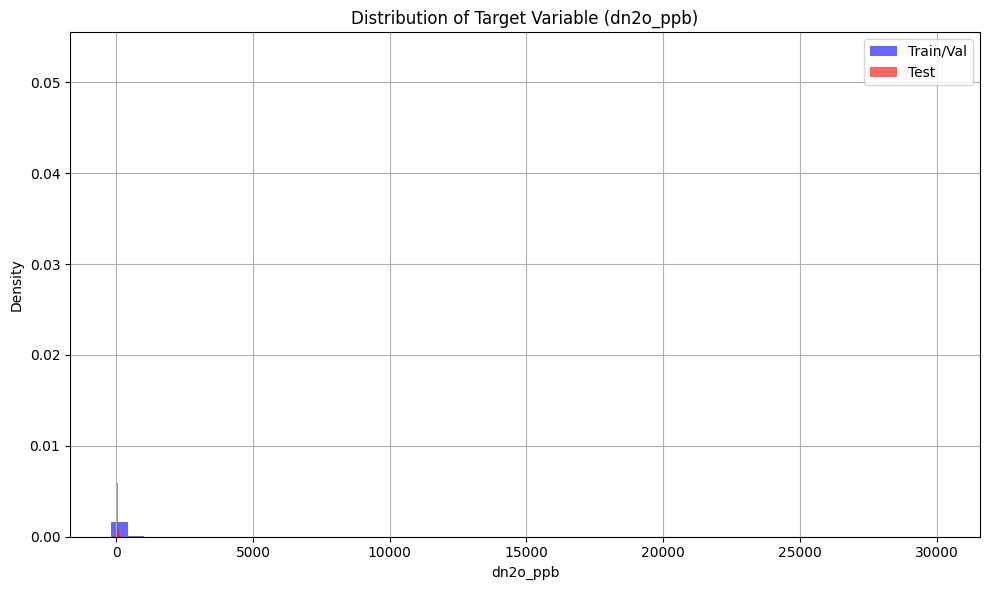

In [ ]:
import matplotlib.pyplot as plt

train_val_targets = targets_np[~global_test_mask_np]
test_targets = targets_np[global_test_mask_np]

print("Train/Val Targets:")
print(f"  Mean: {train_val_targets.mean():.2f}, Std: {train_val_targets.std():.2f}")
print(f"  Min: {train_val_targets.min():.2f}, Max: {train_val_targets.max():.2f}")

print("\nTest Targets:")
print(f"  Mean: {test_targets.mean():.2f}, Std: {test_targets.std():.2f}")
print(f"  Min: {test_targets.min():.2f}, Max: {test_targets.max():.2f}")


plt.figure(figsize=(10, 6))
plt.hist(train_val_targets, bins=50, alpha=0.6, label='Train/Val', color='blue', density=True)
plt.hist(test_targets, bins=50, alpha=0.6, label='Test', color='red', density=True)
plt.xlabel('dn2o_ppb')
plt.ylabel('Density')
plt.title('Distribution of Target Variable (dn2o_ppb)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


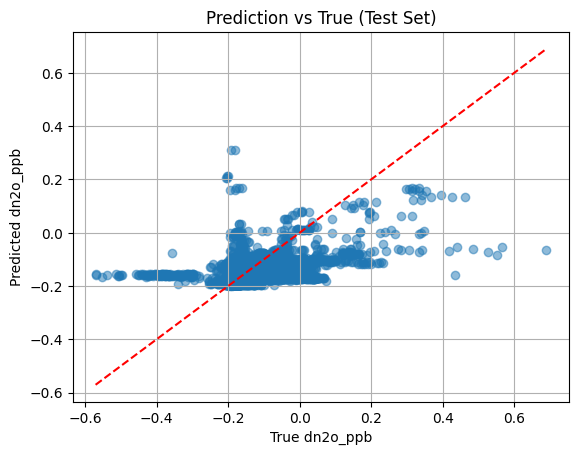

In [ ]:
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel('True dn2o_ppb')
plt.ylabel('Predicted dn2o_ppb')
plt.title('Prediction vs True (Test Set)')
plt.grid(True)
plt.show()


inny encoder, inny regresor

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from tqdm import tqdm


patches = np.load('woa_3x3_patches.npy')  # (N, 3, 3, C)
valid = ~np.isnan(patches).any(axis=(1, 2, 3))
patches = patches[valid]

mean = patches.mean(axis=(0, 1, 2), keepdims=True)
std = patches.std(axis=(0, 1, 2), keepdims=True) + 1e-8
patches = (patches - mean) / std


center_pixel = patches[:, 1, 1, :]  # (N, C)
context = np.delete(patches.reshape(len(patches), 3*3, -1), 4, axis=1)  # usuń środek (N, 8, C)


X = torch.tensor(context, dtype=torch.float32)  # (N, 8, C)
y = torch.tensor(center_pixel, dtype=torch.float32)  # (N, C)


dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=512, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=1024, shuffle=False, num_workers=2, pin_memory=True)


class ReprNet(nn.Module):
    def __init__(self, in_channels, repr_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),  # (8, C) → (8*C,)
            nn.Linear(8 * in_channels, 256),
            nn.ReLU(),
            nn.Linear(256, repr_dim),
            nn.ReLU(),
        )
        self.regressor = nn.Linear(repr_dim, in_channels)  # output: (C,)

    def forward(self, x):
        z = self.encoder(x)
        out = self.regressor(z)
        return out, z


def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for x_batch, y_batch in tqdm(loader, desc="Train", leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        pred, _ = model(x_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    for x_batch, y_batch in tqdm(loader, desc="Valid", leave=False):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        pred, _ = model(x_batch)
        loss = criterion(pred, y_batch)
        total_loss += loss.item()
    return total_loss / len(loader)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ReprNet(in_channels=y.shape[1], repr_dim=64).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

best_val = float('inf')
patience, no_improve = 10, 0
epochs = 50

print("Training for representation learning...")
for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = validate(model, val_loader, criterion, device)
    scheduler.step()

    print(f"Epoch {epoch+1:03d}/{epochs} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}")

    if val_loss < best_val:
        best_val = val_loss
        no_improve = 0
        torch.save(model.state_dict(), "best_reprnet.pth")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping.")
            break

print("Saving final model...")
model.load_state_dict(torch.load("best_reprnet.pth"))
torch.save(model.state_dict(), "final_reprnet.pth")
print("Done.")


Training for representation learning...


Epoch 001/50 | Train Loss: 0.00576 | Val Loss: 0.00007


Epoch 002/50 | Train Loss: 0.00007 | Val Loss: 0.00008


Epoch 003/50 | Train Loss: 0.00007 | Val Loss: 0.00005


Epoch 004/50 | Train Loss: 0.00006 | Val Loss: 0.00004


Epoch 005/50 | Train Loss: 0.00006 | Val Loss: 0.00007


Epoch 006/50 | Train Loss: 0.00005 | Val Loss: 0.00006


Epoch 007/50 | Train Loss: 0.00005 | Val Loss: 0.00006


Epoch 008/50 | Train Loss: 0.00005 | Val Loss: 0.00008


Epoch 009/50 | Train Loss: 0.00004 | Val Loss: 0.00004


Epoch 010/50 | Train Loss: 0.00004 | Val Loss: 0.00003


Epoch 011/50 | Train Loss: 0.00004 | Val Loss: 0.00003


Epoch 012/50 | Train Loss: 0.00003 | Val Loss: 0.00005


Epoch 013/50 | Train Loss: 0.00003 | Val Loss: 0.00003


Epoch 014/50 | Train Loss: 0.00003 | Val Loss: 0.00003


Epoch 015/50 | Train Loss: 0.00002 | Val Loss: 0.00002


Epoch 016/50 | Train Loss: 0.00002 | Val Loss: 0.00002


Epoch 017/50 | Train Loss: 0.00002 | Val Loss: 0.00002


Epoch 018/50 | Train Loss: 0.00002 | Val Loss: 0.00002


Epoch 019/50 | Train Loss: 0.00002 | Val Loss: 0.00002


Epoch 020/50 | Train Loss: 0.00002 | Val Loss: 0.00002


Epoch 021/50 | Train Loss: 0.00002 | Val Loss: 0.00001


Epoch 022/50 | Train Loss: 0.00002 | Val Loss: 0.00001


Epoch 023/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 024/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 025/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 026/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 027/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 028/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 029/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 030/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 031/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 032/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 033/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 034/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 035/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 036/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 037/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 038/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 039/50 | Train Loss: 0.00001 | Val Loss: 0.00002


Epoch 040/50 | Train Loss: 0.00001 | Val Loss: 0.00001


Epoch 041/50 | Train Loss: 0.00001 | Val Loss: 0.00002


Epoch 042/50 | Train Loss: 0.00002 | Val Loss: 0.00002
Early stopping.
Saving final model...
Done.
